## Rename the data

In [1]:
import pandas as pd
import numpy as np

In [2]:
data_raw = pd.read_csv("../data/AAPL_05222012_0930_1300_LOB_2.csv", index_col='Index')

In [3]:
cols = [name.split("..")[0].split(".")[1].lower() for name in data_raw.columns.values if len(name) > 5]

In [4]:
data_raw.columns = ["Time"] + cols

In [5]:
data_raw.head()

,Time,bid_price1,bid_update_time1,bid_size1,ask_price1,ask_update_time1,ask_size1,bid_price2,bid_update_time2,bid_size2,...,bid_size9,ask_price9,ask_update_time9,ask_size9,bid_price10,bid_update_time10,bid_size10,ask_price10,ask_update_time10,ask_size10
Index,,,,,,,,,,,,,,,,,,,,,
1,2012/05/22 09:30:00.000,569.02,2012/05/22 09:29:34.006,40,570,2012/05/22 09:29:43.573,400,568.80,2012/05/22 09:29:47.563,100,...,200,571.00,2012/05/22 09:29:49.424,120,567.16,2012/05/22 09:28:28.730,60,571.24,2012/05/22 08:13:36.797,200
2,2012/05/22 09:30:00.003,569.02,2012/05/22 09:29:34.006,40,570,2012/05/22 09:29:43.573,400,568.80,2012/05/22 09:29:47.563,100,...,200,570.99,2012/05/22 09:29:53.347,200,567.16,2012/05/22 09:28:28.730,60,571.00,2012/05/22 09:29:49.424,120
3,2012/05/22 09:30:00.003,569.02,2012/05/22 09:29:34.006,40,570,2012/05/22 09:29:43.573,400,568.80,2012/05/22 09:29:47.563,100,...,200,570.67,2012/05/22 09:29:29.034,10,567.16,2012/05/22 09:28:28.730,60,570.99,2012/05/22 09:29:53.347,200
4,2012/05/22 09:30:00.003,569.03,2012/05/22 09:30:00.003,8,570,2012/05/22 09:29:43.573,400,569.02,2012/05/22 09:29:34.006,40,...,200,570.67,2012/05/22 09:29:29.034,10,567.30,2012/05/22 09:29:38.985,200,570.99,2012/05/22 09:29:53.347,200
5,2012/05/22 09:30:00.003,569.03,2012/05/22 09:30:00.003,8,570,2012/05/22 09:29:43.573,400,569.02,2012/05/22 09:29:34.006,40,...,200,570.55,2012/05/22 09:30:00.003,8,567.30,2012/05/22 09:29:38.985,200,570.67,2012/05/22 09:29:29.034,10


In [6]:
data_raw.to_csv("../data/AAPL_LOB.csv")

## Fit the models

In [3]:
from imp import reload

In [1]:
import pandas as pd
import numpy as np
from datetime import datetime
from label import create_label
from basic_set import get_basic
from insensitive_set import get_spread_midprice, get_price_diff, get_mean, get_accumulated_diff
from sensitive_set import get_derivatives
from sampling import sampling_labels, general_sampling
from sklearn import svm
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import RandomForestClassifier as RF

In [23]:
from sklearn.ensemble import RandomForestClassifier as RF

In [2]:
from matplotlib import pyplot as plt
%matplotlib inline

In [4]:
plt.style.use("ggplot")

### Load data

In [332]:
data_raw = pd.read_csv('../data/AAPL_LOB.csv')

### Transform the data

In [6]:
def transform_data_tinsen(data_raw):
    spreads_mids = get_spread_midprice(data_raw)
    price_diff = get_price_diff(data_raw)
    means = get_mean(data_raw)
    accum_diff = get_accumulated_diff(data_raw)
    data_tfm = pd.merge(spreads_mids, price_diff, on = ['Index', 'Time'])
    data_tfm = pd.merge(data_tfm, means, on = ['Index', 'Time'])
    data_tfm = pd.merge(data_tfm, accum_diff, on = ['Index', 'Time'])
    return(data_tfm)

In [7]:
def transform_data(data_raw, feature_basic = True, feature_tinsen = True, feature_tsen = True, delta_t = 30):
    if feature_basic * feature_tinsen * feature_tsen:
        basics = get_basic(data_raw)
        data_tinsen = transform_data_tinsen(data_raw)
        data_tsen = get_derivatives(data_raw, delta_t)
        basics = basics.iloc[delta_t:]
        data_tinsen = data_tinsen.iloc[delta_t:]
        #print("basics_ind:" + str(basics.index[:5]) + "tinsen: "+ str(data_tinsen.index[:5]) + str(data_tsen.index[:5]))
        data_tfm = pd.merge(basics, data_tinsen, on = ['Index', 'Time'])
        data_tfm = pd.merge(data_tfm, data_tsen, on = ['Index', 'Time'])
        return(data_tfm)
    elif (feature_basic == True) and (feature_tinsen == True):
        basics = get_basic(data_raw)
        data_tinsen = transform_data_tinsen(data_raw)
        data_tfm = pd.merge(basics, data_tinsen, on = ['Index', 'Time'])
        return(data_tfm)
    elif (feature_basic == True):
        basics = get_basic(data_raw)
        return(basics)

In [8]:
def split_rawdata(data_raw, split_time = datetime(2012, 5, 22, 11, 0)):
    time = np.array([datetime.strptime(time, "%Y/%m/%d %H:%M:%S.%f") for time in data_raw['Time']])
    train_index = time < datetime(2012, 5, 22, 11, 0)
    train = data_raw.iloc[train_index]
    test = data_raw.iloc[ np.logical_and(np.logical_not(train_index),time <= datetime(2012, 5, 22, 12, 0))]
    return({"train": train, "test": test})

In [551]:
raw_data_sets = split_rawdata(data_raw)
train = raw_data_sets["train"]
test = raw_data_sets["test"]

In [399]:
test.shape

(76307, 62)

In [553]:
train_tfm = transform_data(train, delta_t = 30)
test_tfm = transform_data(test, delta_t = 30)

In [562]:
#test_tfm.head()
test_tfm.shape

(76277, 128)

## Prepare y labels

#### Mid price based on delta_t = 20

***try without sampling***

Just use ~50% for training, ~25% for validating and ~25% for testing within the 9-11am dataset

In [30]:
#validation_x.index = range(validation_x.shape[0])
#train_x.index = range(train_x.shape[0])
#test_x.index = range(test_x.shape[0])

In [563]:
y_lab_train_all = create_label(train_tfm, 30)
y_lab_train_all.shape

(203289, 130)

In [564]:
test_all = create_label(test_tfm, 30)

In [565]:
test_all.shape

(76247, 130)

In [404]:
y_lab_train_all.spread_label.value_counts()

stationary    199525
down            2144
up              1620
dtype: int64

In [405]:
y_lab_train_all.mid_label.value_counts()

down          78922
up            73735
stationary    50632
dtype: int64

In [566]:
index = np.arange(y_lab_train_all.shape[0])
np.random.seed(9)
# Shuffle the index and separate the data into train(50%), validation(25%), and test(25%) set.
np.random.shuffle(index)

# approximate subset
train_x = train_tfm.iloc[index[0:101659]]
validation_x = train_tfm.iloc[index[101659:152489]]
test_x = train_tfm.iloc[index[152489:]]

train_y = y_lab_train_all.iloc[index[0:101659]]
validation_y = y_lab_train_all.iloc[index[101659:152489]]
test_y = y_lab_train_all.iloc[index[152489:]]


In [567]:
print(train_x.shape)
print(validation_x.shape)
print(test_x.shape)
print(train_y.shape)
print(validation_y.shape)
print(test_y.shape)

(101659, 130)
(50830, 130)
(50800, 130)
(101659, 130)
(50830, 130)
(50800, 130)


In [19]:
def cal_measure(CM):
    '''
    input: 3 by 3 confusion matrix
    output: data frame of measurements
    '''
    # for Up (0)
    up = np.array([[CM[0,0],(CM[0,1]+CM[0,2])],[(CM[1,0]+CM[2,0]),(CM[1,1]+CM[2,2]+CM[1,2]+CM[2,1])]], dtype='float')
    station = np.array([[CM[1,1],(CM[1,0]+CM[1,2])],[(CM[0,1]+CM[2,1]),(CM[0,0]+CM[2,2]+CM[0,2]+CM[2,0])]], dtype='float')
    down = np.array([[CM[2,2],(CM[2,0]+CM[2,1])],[(CM[0,2]+CM[1,2]),(CM[0,0]+CM[1,1]+CM[0,1]+CM[1,0])]], dtype='float')
    p_up = up[0,0]/(up[0,0]+up[1,0])
    p_station = station[0,0]/(station[0,0]+station[1,0])
    p_down = down[0,0]/(down[0,0]+down[1,0])
    r_up = up[0,0]/(up[0,0]+up[0,1])
    r_station = station[0,0]/(station[0,0]+station[0,1])
    r_down = down[0,0]/(down[0,0]+down[0,1])
    f_up = 2*p_up*r_up/(p_up+r_up)
    f_station = 2*p_station*r_station/(p_station+r_station)
    f_down = 2*p_down*r_down/(p_down+r_down)
    measure=pd.DataFrame(index=['Up','Stationary','Down'])
    measure['Precision'] = [p_up,p_station,p_down]
    measure['Recall'] = [r_up,r_station,r_down]
    measure['F1_Measure'] = [f_up,f_station,f_down]
    return measure

### Mid-Price Based Model Fitting

Sample from the training set and validation set.

In [343]:
train_sample = general_sampling(train_x, 10000, mid=True, sample_random=True)
valid_sample = general_sampling(validation_x, 10000, mid=True, sample_random=True)

In [344]:
train_sample.mid_label.value_counts()

down          3903
up            3597
stationary    2500
dtype: int64

In [290]:
train_accmat = []
valid_accmat = []
for d in [5,10,20]:
    for n in [10,50,100,250,500]:
        cand = RF(n_estimators=n, max_depth=d, max_features='sqrt')
        cand = cand.fit(train_sample[train_sample.columns[2:-2]], train_sample.mid_label)
        predict_train = cand.predict(train_sample[train_sample.columns[2:-2]])
        CM_train = confusion_matrix(predict_train, train_sample['mid_label'])
        predict_valid = cand.predict(valid_sample[valid_sample.columns[2:-2]])
        CM_valid = confusion_matrix(predict_valid, valid_sample['mid_label'])
        train_accmat.append(cal_measure(CM_train))
        valid_accmat.append(cal_measure(CM_valid))
        print((n,d))

(10, 5)
(50, 5)
(100, 5)
(250, 5)
(500, 5)
(10, 10)
(50, 10)
(100, 10)
(250, 10)
(500, 10)
(10, 20)
(50, 20)
(100, 20)
(250, 20)
(500, 20)


In [291]:
valid_up_f1 = [pd.ix['Up']['F1_Measure'] for pd in valid_accmat]
valid_down_f1 = [pd.ix['Down']['F1_Measure'] for pd in valid_accmat]
valid_stat_f1 = [pd.ix['Stationary']['F1_Measure'] for pd in valid_accmat]

In [292]:
train_up_f1 = [pd.ix['Up']['F1_Measure'] for pd in train_accmat]
train_down_f1 = [pd.ix['Down']['F1_Measure'] for pd in train_accmat]
train_stat_f1 = [pd.ix['Stationary']['F1_Measure'] for pd in train_accmat]

In [293]:
valid_accmat

[            Precision    Recall  F1_Measure
 Up           0.655370  0.457073    0.538548
 Stationary   0.028951  0.757895    0.055771
 Down         0.514571  0.433871    0.470788,
             Precision    Recall  F1_Measure
 Up           0.674558  0.458891    0.546207
 Stationary   0.015682  0.886364    0.030818
 Down         0.506571  0.437022    0.469234,
             Precision    Recall  F1_Measure
 Up           0.664590  0.460145    0.543786
 Stationary   0.012063  0.967742    0.023828
 Down         0.523143  0.438773    0.477258,
             Precision    Recall  F1_Measure
 Up           0.675554  0.458171    0.546022
 Stationary   0.014073  0.945946    0.027734
 Down         0.508857  0.440188    0.472038,
             Precision    Recall  F1_Measure
 Up           0.673561  0.458991    0.545950
 Stationary   0.012465  0.939394    0.024603
 Down         0.514000  0.441148    0.474795,
             Precision    Recall  F1_Measure
 Up           0.630451  0.495301    0.554764
 Stat

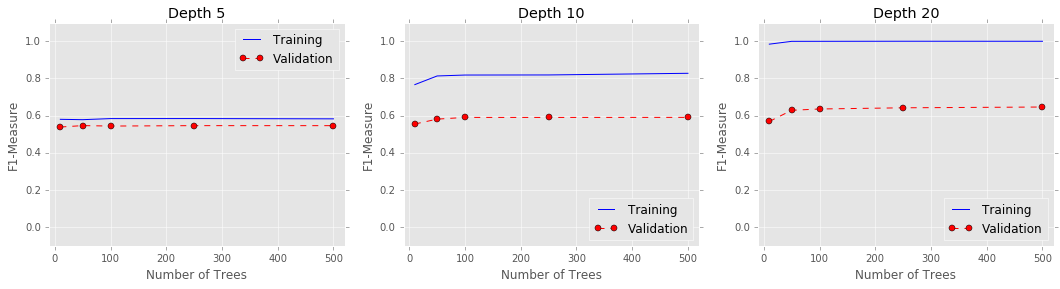

In [295]:
# Up
n = [10,50,100,250,500]
d = [5,10,20]
fig = plt.figure(figsize = (18,4))
for plot_number in range(1,4):
    axis = fig.add_subplot(1, 3, plot_number)
    axis.plot(n, train_up_f1[(plot_number-1)*5:plot_number*5], color = 'b', label='Training')
    axis.plot(n, valid_up_f1[(plot_number-1)*5:plot_number*5], marker='o', linestyle='--', color='r', label='Validation')
    axis.set_xlabel('Number of Trees')
    axis.set_ylabel('F1-Measure')
    axis.set_title('Depth ' + str(d[plot_number-1]))
    axis.set_xlim(-10, 520)
    axis.set_ylim(-0.1, 1.1)
    if plot_number == 1:
        axis.legend(loc=1)
    else:
        axis.legend(loc=4)
plt.show()

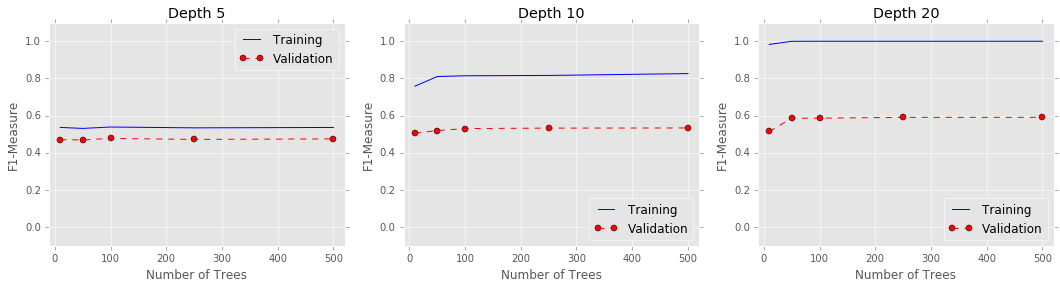

In [296]:
# Down
n = [10,50,100,250,500]
d = [5,10,20]
fig = plt.figure(figsize = (18, 4))
for plot_number in range(1,4):
    axis = fig.add_subplot(1, 3, plot_number)
    axis.plot(n, train_down_f1[(plot_number-1)*5:plot_number*5], color = 'b', label='Training')
    axis.plot(n, valid_down_f1[(plot_number-1)*5:plot_number*5], marker='o', linestyle='--', color='r', label='Validation')
    axis.set_xlabel('Number of Trees')
    axis.set_ylabel('F1-Measure')
    axis.set_title('Depth ' + str(d[plot_number-1]))
    axis.set_xlim(-10, 520)
    axis.set_ylim(-0.1, 1.1)
    if plot_number == 1:
        axis.legend(loc=1)
    else:
        axis.legend(loc=4)
plt.show()

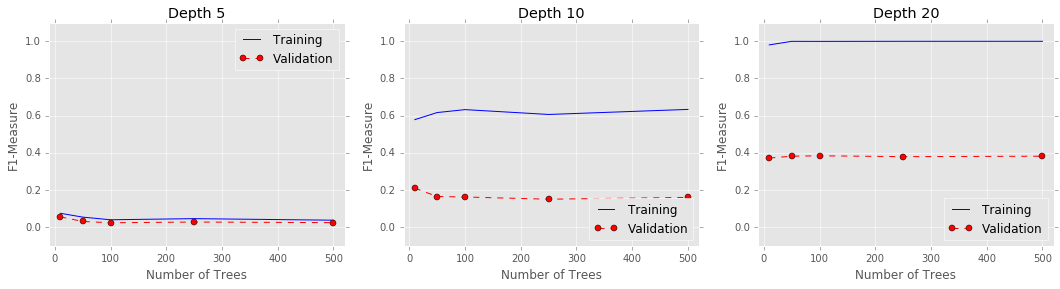

In [302]:
# Stationary
n = [10,50,100,250,500]
d = [5,10,20]
fig = plt.figure(figsize = (18, 4))
for plot_number in range(1,4):
    axis = fig.add_subplot(1, 3, plot_number)
    axis.plot(n, train_stat_f1[(plot_number-1)*5:plot_number*5], color = 'b', label='Training')
    axis.plot(n, valid_stat_f1[(plot_number-1)*5:plot_number*5], marker='o', linestyle='--', color='r', label='Validation')
    axis.set_xlabel('Number of Trees')
    axis.set_ylabel('F1-Measure')
    axis.set_title('Depth ' + str(d[plot_number-1]))
    axis.set_xlim(-10, 520)
    axis.set_ylim(-0.1, 1.1)
    if plot_number == 1:
        axis.legend(loc=1)
    else:
        axis.legend(loc=4)
plt.show()

In [345]:
first_x = train_tfm.iloc[index[0:152489]]
test_x = train_tfm.iloc[index[152489:]]
train_sample = general_sampling(first_x, 20000, mid=True, sample_random=True)

In [346]:
first_x.shape

(152489, 130)

In [353]:
cand = RF(n_estimators=500, max_depth=20, max_features='sqrt')
cand = cand.fit(first_x[first_x.columns[2:-2]], first_x.mid_label)
predict = cand.predict(test_x[test_x.columns[2:-2]])
CM = confusion_matrix(predict, test_x['mid_label'])

In [350]:
#cand = RF(n_estimators=500, max_depth=20, max_features='sqrt')
#cand = cand.fit(train_sample[train_sample.columns[2:-2]], train_sample.mid_label)
#predict = cand.predict(test_x[test_x.columns[2:-2]])
#CM_1 = confusion_matrix(predict, test_x['mid_label'])

In [354]:
CM

array([[18336,  1942,   913],
       [  539,  9224,   555],
       [  742,  1526, 17023]])

In [355]:
cal_measure(CM)

,Precision,Recall,F1_Measure
Up,0.934699,0.865273,0.898647
Stationary,0.726757,0.893972,0.801738
Down,0.920610,0.882432,0.901117


In [356]:
fea_imp = cand.feature_importances_

In [357]:
sorted(fea_imp, reverse=True)

[0.017290959491840875,
 0.015778208332209796,
 0.01507552825747947,
 0.014150560488286085,
 0.013797454806573087,
 0.013369390209936332,
 0.013159575354872633,
 0.012280462710187829,
 0.01207946218392489,
 0.011784949298842395,
 0.011628232392451634,
 0.011603778667247438,
 0.011237638650735286,
 0.011116966704480476,
 0.010878521114173459,
 0.010864970728579369,
 0.010638790621687344,
 0.010037150822084825,
 0.0099229568932033534,
 0.0097469657690285715,
 0.0096585043135393959,
 0.0095757594918642382,
 0.0095566657624432914,
 0.0093621479215764448,
 0.0092980973749949014,
 0.0090727480762425421,
 0.0090661649144584983,
 0.0090244733578068795,
 0.0088171535994552956,
 0.0088066089408514042,
 0.0087948164735735419,
 0.0087698795393591177,
 0.0087625018128972137,
 0.0086773947962617611,
 0.008612655926923684,
 0.0086075360168483099,
 0.0085688713825790505,
 0.0085309540650785609,
 0.0084359596541123925,
 0.0084058655225172606,
 0.0083976081126516909,
 0.0083403845897303801,
 0.0083170988

In [358]:
first_x.columns[2:-2][np.argsort(fea_imp)[::-1]][:20]

Index(['ask_size1', 'size_accumulated_diff', 'mean_ask_vol', 'mean_bid_vol',
       'bid-ask_spread1', 'bid_size1', 'ask_size_derivative1',
       'bid_size_derivative1', 'ask_price_derivative1', 'bid_diff',
       'bid_price_derivative1', 'ask_diff', 'bid_abs2_1',
       'price_accumulated_diff', 'bid_price_derivative2', 'bid-ask_spread2',
       'ask_abs2_1', 'ask_price_derivative2', 'ask_size2', 'ask_size3'],
      dtype='object')

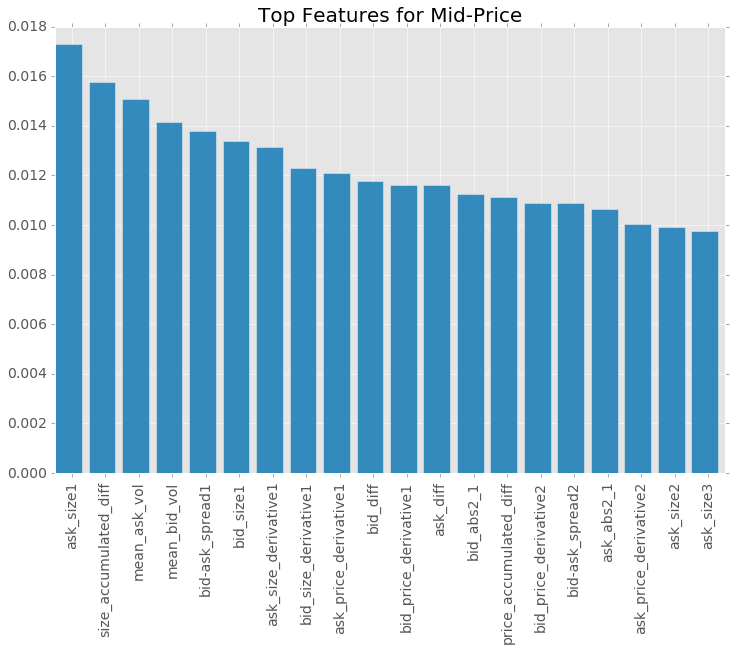

In [359]:
y=sorted(fea_imp, reverse=True)[:20]
x=range(20)
top_fea = list(first_x.columns[2:-2][np.argsort(fea_imp)[::-1]][:20])
plt.figure(figsize = (12, 8))
plt.bar(x,y)
xx=np.arange(20)+0.5
plt.xticks(xx, top_fea, rotation='vertical')
plt.tick_params(labelsize=14)
plt.title("Top Features for Mid-Price", fontsize=20)
plt.show()

In [360]:
#cand = RF(n_estimators=250, max_depth=18, max_features='sqrt')
#cand = cand.fit(train_sample[top_fea], train_sample.mid_label)
#predict = cand.predict(test_x[top_fea])
#CM = confusion_matrix(predict, test_x['mid_label'])

In [363]:
cand_1 = RF(n_estimators=250, max_depth=18, max_features='sqrt')
cand_1 = cand_1.fit(first_x[top_fea], first_x.mid_label)
predict = cand_1.predict(test_x[top_fea])
CM_1 = confusion_matrix(predict, test_x['mid_label'])

In [364]:
CM_1

array([[17998,  2278,  1417],
       [  452,  8621,   497],
       [ 1167,  1793, 16577]])

In [365]:
cal_measure(CM_1)

,Precision,Recall,F1_Measure
Up,0.917470,0.829669,0.871363
Stationary,0.679247,0.900836,0.774504
Down,0.896490,0.848493,0.871831


In [368]:
predict = cand_1.predict(test_all[top_fea])
CM_2 = confusion_matrix(predict, test_all['mid_label'])

In [369]:
CM_2

array([[18492, 14352,  9964],
       [  866,  1425,   580],
       [ 8323,  9451, 12794]])

In [370]:
cal_measure(CM_2)

,Precision,Recall,F1_Measure
Up,0.668039,0.431975,0.524678
Stationary,0.056485,0.496343,0.101427
Down,0.548205,0.418542,0.474678


### Spread-Crossing Based Model Fitting

Sample from the training and validation set.

In [568]:
train_x.shape

(101659, 130)

In [409]:
train_sample = general_sampling(train_x, 10000, mid=False, up_prob=0.1,down_prob=0.1)
valid_sample = general_sampling(validation_x, 10000, mid=False, sample_random=True)

In [125]:
train_sample.columns[-2:]

Index(['mid_label', 'spread_label'], dtype='object')

In [410]:
train_sample.spread_label.value_counts()

stationary    8000
up            1000
down          1000
dtype: int64

#### Random Forest

In [411]:
train_accmat = []
valid_accmat = []
for d in [5,10,20]:
    for n in [10,50,100,250,500]:
        cand = RF(n_estimators=n, max_depth=d, max_features='sqrt')
        cand = cand.fit(train_sample[train_sample.columns[2:-2]], train_sample.spread_label)
        predict_train = cand.predict(train_sample[train_sample.columns[2:-2]])
        CM_train = confusion_matrix(predict_train, train_sample['spread_label'])
        predict_valid = cand.predict(valid_sample[valid_sample.columns[2:-2]])
        CM_valid = confusion_matrix(predict_valid, valid_sample['spread_label'])
        train_accmat.append(cal_measure(CM_train))
        valid_accmat.append(cal_measure(CM_valid))
        print((n,d))

(10, 5)
(50, 5)
(100, 5)
(250, 5)
(500, 5)
(10, 10)
(50, 10)
(100, 10)
(250, 10)
(500, 10)
(10, 20)
(50, 20)
(100, 20)
(250, 20)
(500, 20)


In [412]:
valid_up_f1 = [pd.ix['Up']['F1_Measure'] for pd in valid_accmat]
valid_down_f1 = [pd.ix['Down']['F1_Measure'] for pd in valid_accmat]
valid_stat_f1 = [pd.ix['Stationary']['F1_Measure'] for pd in valid_accmat]

In [413]:
train_up_f1 = [pd.ix['Up']['F1_Measure'] for pd in train_accmat]
train_down_f1 = [pd.ix['Down']['F1_Measure'] for pd in train_accmat]
train_stat_f1 = [pd.ix['Stationary']['F1_Measure'] for pd in train_accmat]

In [97]:
v=valid_accmat

In [138]:
#valid_accmat

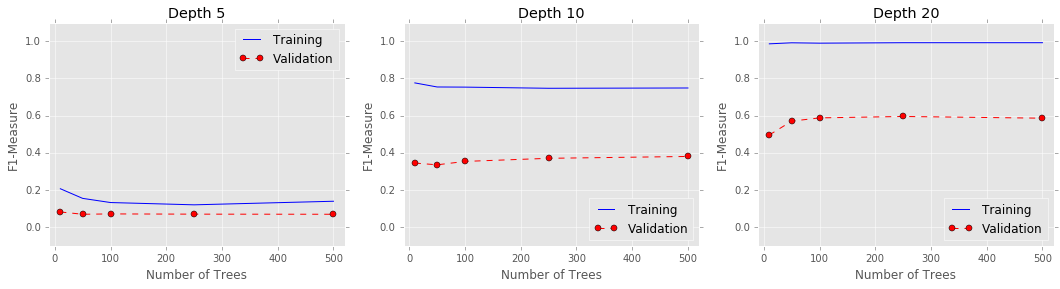

In [414]:
# Up
n = [10,50,100,250,500]
d = [5,10,20]
fig = plt.figure(figsize = (18,4))
for plot_number in range(1,4):
    axis = fig.add_subplot(1, 3, plot_number)
    axis.plot(n, train_up_f1[(plot_number-1)*5:plot_number*5], color = 'b', label='Training')
    axis.plot(n, valid_up_f1[(plot_number-1)*5:plot_number*5], marker='o', linestyle='--', color='r', label='Validation')
    axis.set_xlabel('Number of Trees')
    axis.set_ylabel('F1-Measure')
    axis.set_title('Depth ' + str(d[plot_number-1]))
    axis.set_xlim(-10, 520)
    axis.set_ylim(-0.1, 1.1)
    if plot_number == 1:
        axis.legend(loc=1)
    else:
        axis.legend(loc=4)
plt.show()

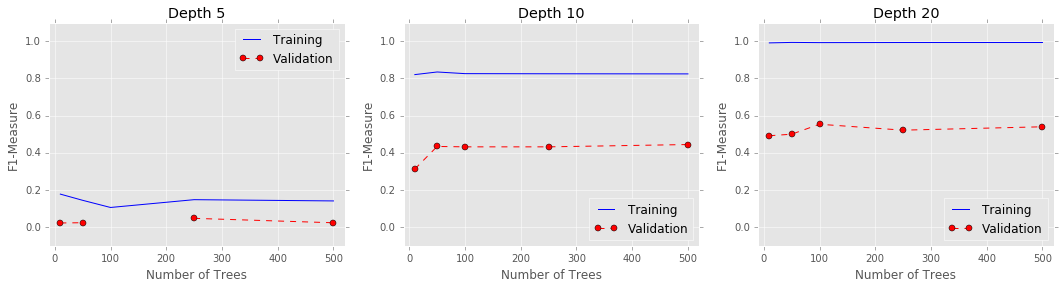

In [415]:
# Down
n = [10,50,100,250,500]
d = [5,10,20]
fig = plt.figure(figsize = (18, 4))
for plot_number in range(1,4):
    axis = fig.add_subplot(1, 3, plot_number)
    axis.plot(n, train_down_f1[(plot_number-1)*5:plot_number*5], color = 'b', label='Training')
    axis.plot(n, valid_down_f1[(plot_number-1)*5:plot_number*5], marker='o', linestyle='--', color='r', label='Validation')
    axis.set_xlabel('Number of Trees')
    axis.set_ylabel('F1-Measure')
    axis.set_title('Depth ' + str(d[plot_number-1]))
    axis.set_xlim(-10, 520)
    axis.set_ylim(-0.1, 1.1)
    if plot_number == 1:
        axis.legend(loc=1)
    else:
        axis.legend(loc=4)
plt.show()

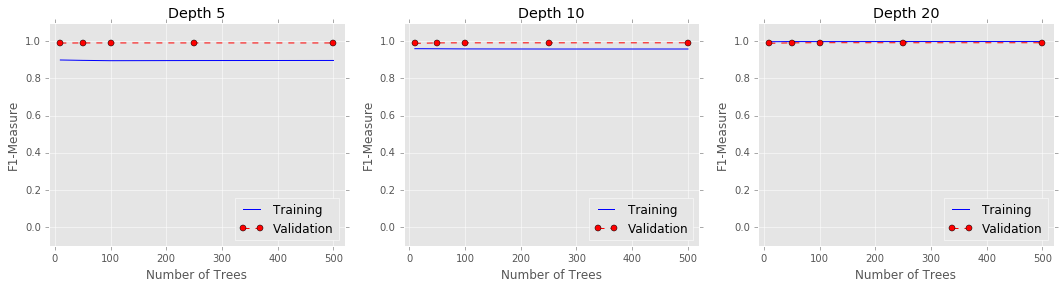

In [416]:
# Stationary
n = [10,50,100,250,500]
d = [5,10,20]
fig = plt.figure(figsize = (18, 4))
for plot_number in range(1,4):
    axis = fig.add_subplot(1, 3, plot_number)
    axis.plot(n, train_stat_f1[(plot_number-1)*5:plot_number*5], color = 'b', label='Training')
    axis.plot(n, valid_stat_f1[(plot_number-1)*5:plot_number*5], marker='o', linestyle='--', color='r', label='Validation')
    axis.set_xlabel('Number of Trees')
    axis.set_ylabel('F1-Measure')
    axis.set_title('Depth ' + str(d[plot_number-1]))
    axis.set_xlim(-10, 520)
    axis.set_ylim(-0.1, 1.1)
    axis.legend(loc=4)
plt.show()

In [569]:
first_x = train_tfm.iloc[index[0:152489]]
first_x.shape[0]

152489

In [570]:
first_x = train_tfm.iloc[index[0:152489]]
test_x = train_tfm.iloc[index[152489:]]
train_sample = general_sampling(first_x, first_x.shape[0], mid=False, up_prob=0.1,down_prob=0.1)

In [571]:
cand = RF(n_estimators=250, max_depth=20, max_features='sqrt')
cand = cand.fit(train_sample[train_sample.columns[2:-2]], train_sample.spread_label)
predict = cand.predict(test_x[test_x.columns[2:-2]])
CM = confusion_matrix(predict, test_x['spread_label'])

In [572]:
CM

array([[  396,    82,     0],
       [  147, 49666,   136],
       [    0,    78,   295]])

In [573]:
cal_measure(CM)

,Precision,Recall,F1_Measure
Up,0.729282,0.828452,0.775710
Stationary,0.996789,0.994334,0.995560
Down,0.684455,0.790885,0.733831


In [422]:
fea_imp = cand.feature_importances_

In [423]:
sorted(fea_imp, reverse=True)

[0.063780493402700769,
 0.036283094932124331,
 0.024857869027805048,
 0.016967266228427452,
 0.01525304368435385,
 0.014752404278535481,
 0.014086492396732793,
 0.01378214180354548,
 0.0131125848637251,
 0.01178640396946435,
 0.01147745098713138,
 0.010982311983394843,
 0.010576408793911633,
 0.010325637005850298,
 0.010258223011371194,
 0.010109764387005445,
 0.0098914278947860781,
 0.0098369752103771215,
 0.0098169587193271471,
 0.0096656094028316954,
 0.0096192283880022229,
 0.0095610010060601918,
 0.0095027057287124309,
 0.0094352566234470053,
 0.0093313165243154167,
 0.008882472004321346,
 0.0088519043587814532,
 0.0084416855677237508,
 0.0083207907354071863,
 0.0082427999580032083,
 0.0081399035562233248,
 0.0080845138825011952,
 0.0079474034445578996,
 0.0079455370503487971,
 0.0079054818918123729,
 0.0078949927503105914,
 0.0078639006765548192,
 0.0077842981300115166,
 0.0076620074733368179,
 0.0075536933236495189,
 0.0075155069952953374,
 0.0074220971333063138,
 0.007411545083

In [424]:
train_sample.columns[2:-2][np.argsort(fea_imp)[::-1]][:20]

Index(['bid-ask_spread1', 'bid-ask_spread2', 'bid-ask_spread3',
       'price_accumulated_diff', 'mean_ask_vol', 'ask_diff', 'bid-ask_spread4',
       'bid_diff', 'size_accumulated_diff', 'ask_size_derivative1',
       'mean_bid_vol', 'bid_abs2_1', 'bid-ask_spread8',
       'ask_price_derivative1', 'ask_size2', 'ask_size5', 'bid-ask_spread6',
       'bid-ask_spread5', 'bid-ask_spread9', 'ask_abs2_1'],
      dtype='object')

In [178]:
#top_fea

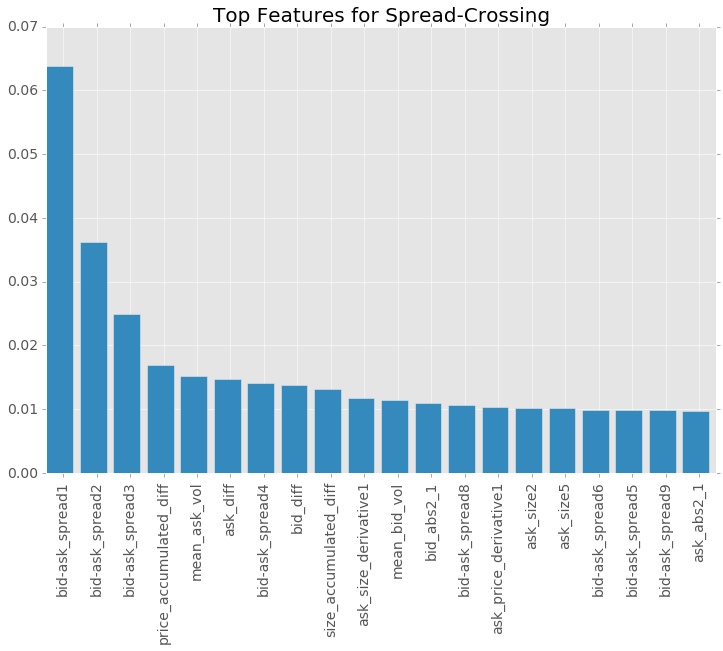

In [425]:
y=sorted(fea_imp, reverse=True)[:20]
x=range(20)
top_fea = list(train_sample.columns[2:-2][np.argsort(fea_imp)[::-1]][:20])
plt.figure(figsize = (12, 8))
plt.bar(x,y)
xx=np.arange(20)+0.5
plt.xticks(xx, top_fea, rotation='vertical')
plt.tick_params(labelsize=14)
plt.title("Top Features for Spread-Crossing", fontsize=20)
plt.show()

In [426]:
cand = RF(n_estimators=100, max_depth=18, max_features='sqrt')
cand = cand.fit(train_sample[top_fea], train_sample.spread_label)
predict = cand.predict(test_x[top_fea])
CM = confusion_matrix(predict, test_x['spread_label'])

In [429]:
CM

array([[  394,    96,     0],
       [  149, 49645,   133],
       [    0,    85,   298]])

In [428]:
cal_measure(CM)

,Precision,Recall,F1_Measure
Up,0.725599,0.804082,0.762827
Stationary,0.996367,0.994352,0.995359
Down,0.691415,0.778068,0.732187


In [431]:
predict = cand.predict(test_all[top_fea])
CM_1 = confusion_matrix(predict, test_all['spread_label'])

In [432]:
CM_1

array([[    0,     0,     0],
       [  349, 75573,   325],
       [    0,     0,     0]])

***split data again to 10:30 and 11:00***

In [574]:
time = np.array([datetime.strptime(time, "%Y/%m/%d %H:%M:%S.%f") for time in data_raw['Time']])
before_11 = data_raw.iloc[time < datetime(2012, 5, 22, 11, 0)]
time = np.array([datetime.strptime(time, "%Y/%m/%d %H:%M:%S.%f") for time in before_11['Time']])
before_11 = before_11.iloc[time >= datetime(2012, 5, 22, 10, 30)]

In [575]:
before_11.shape
#test_all.shape

(59061, 62)

In [576]:
before_11_tfm = transform_data(before_11, delta_t = 30)

In [577]:
before_11_tfm.shape

(59031, 128)

In [578]:
before_11_x = create_label(before_11_tfm, 30)
before_11_x.shape

(59001, 130)

In [580]:
before_11_x.spread_label.value_counts()

stationary    58244
up              388
down            369
dtype: int64

In [521]:
train_sample = general_sampling(before_11_x, 10000, mid=False, up_prob=0.1,down_prob=0.1)
valid_sample = general_sampling(test_all, 10000, mid=False, sample_random=True)

In [522]:
train_accmat = []
valid_accmat = []
for d in [5,10,20]:
    for n in [10,50,100,250,500]:
        cand = RF(n_estimators=n, max_depth=d, max_features='sqrt')
        cand = cand.fit(train_sample[train_sample.columns[2:-2]], train_sample.spread_label)
        predict_train = cand.predict(train_sample[train_sample.columns[2:-2]])
        CM_train = confusion_matrix(predict_train, train_sample['spread_label'])
        predict_valid = cand.predict(valid_sample[valid_sample.columns[2:-2]])
        CM_valid = confusion_matrix(predict_valid, valid_sample['spread_label'])
        train_accmat.append(cal_measure(CM_train))
        valid_accmat.append(cal_measure(CM_valid))
        print((n,d))

(10, 5)
(50, 5)
(100, 5)
(250, 5)
(500, 5)
(10, 10)
(50, 10)
(100, 10)
(250, 10)
(500, 10)
(10, 20)
(50, 20)
(100, 20)
(250, 20)
(500, 20)


In [523]:
valid_up_f1 = [pd.ix['Up']['Recall'] for pd in valid_accmat]
valid_down_f1 = [pd.ix['Down']['Recall'] for pd in valid_accmat]
valid_stat_f1 = [pd.ix['Stationary']['Recall'] for pd in valid_accmat]

In [524]:
train_up_f1 = [pd.ix['Up']['Recall'] for pd in train_accmat]
train_down_f1 = [pd.ix['Down']['Recall'] for pd in train_accmat]
train_stat_f1 = [pd.ix['Stationary']['Recall'] for pd in train_accmat]

In [525]:
valid_accmat

[            Precision    Recall  F1_Measure
 Up           0.000000  0.000000         NaN
 Stationary   0.998886  0.987787    0.993305
 Down         0.000000  0.000000         NaN,
             Precision  Recall  F1_Measure
 Up                  0     NaN         NaN
 Stationary          1  0.9878    0.993863
 Down                0     NaN         NaN,
             Precision  Recall  F1_Measure
 Up                  0     NaN         NaN
 Stationary          1  0.9878    0.993863
 Down                0     NaN         NaN,
             Precision  Recall  F1_Measure
 Up                  0     NaN         NaN
 Stationary          1  0.9878    0.993863
 Down                0     NaN         NaN,
             Precision  Recall  F1_Measure
 Up                  0     NaN         NaN
 Stationary          1  0.9878    0.993863
 Down                0     NaN         NaN,
             Precision    Recall  F1_Measure
 Up           0.000000       NaN         NaN
 Stationary   0.999696  0.987796    0

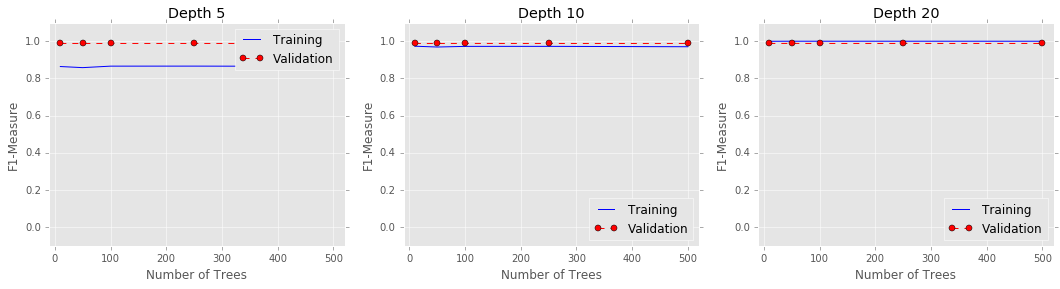

In [528]:
# Up
n = [10,50,100,250,500]
d = [5,10,20]
fig = plt.figure(figsize = (18,4))
for plot_number in range(1,4):
    axis = fig.add_subplot(1, 3, plot_number)
    axis.plot(n, train_stat_f1[(plot_number-1)*5:plot_number*5], color = 'b', label='Training')
    axis.plot(n, valid_stat_f1[(plot_number-1)*5:plot_number*5], marker='o', linestyle='--', color='r', label='Validation')
    axis.set_xlabel('Number of Trees')
    axis.set_ylabel('F1-Measure')
    axis.set_title('Depth ' + str(d[plot_number-1]))
    axis.set_xlim(-10, 520)
    axis.set_ylim(-0.1, 1.1)
    if plot_number == 1:
        axis.legend(loc=1)
    else:
        axis.legend(loc=4)
plt.show()

In [588]:
cand_11 = RF(n_estimators=250, max_depth=20, max_features='sqrt')
cand_11 = cand_11.fit(before_11_x[before_11_x.columns[2:-2]], before_11_x.spread_label)
predict = cand_11.predict(test_all[test_all.columns[2:-2]])
CM_11 = confusion_matrix(predict, test_all['spread_label'])

In [592]:
train_sample = general_sampling(before_11_x, before_11_x.shape[0], mid=False, up_prob=0.1,down_prob=0.1)
cand_11 = RF(n_estimators=250, max_depth=20, max_features='sqrt')
cand_11 = cand_11.fit(train_sample[train_sample.columns[2:-2]], train_sample.spread_label)
predict = cand_11.predict(test_all[test_all.columns[2:-2]])
CM_11 = confusion_matrix(predict, test_all['spread_label'])

In [596]:
#train_sample = general_sampling(before_11_x, before_11_x.shape[0], mid=False, up_prob=0.1,down_prob=0.1)
cand_11 = RF(n_estimators=250, max_depth=20, max_features='sqrt')
cand_11 = cand_11.fit(test_all[test_all.columns[2:-2]], test_all.spread_label)
predict = cand_11.predict(test_all[test_all.columns[2:-2]])
CM_11 = confusion_matrix(predict, test_all['spread_label'])

In [583]:
predict = cand.predict(test_all[test_all.columns[2:-2]])
CM_11 = confusion_matrix(predict, test_all['spread_label'])

In [597]:
CM_11

array([[  332,     0,     0],
       [   17, 75573,    17],
       [    0,     0,   308]])

In [585]:
predict[-30:]

array(['stationary', 'stationary', 'stationary', 'stationary',
       'stationary', 'stationary', 'stationary', 'stationary',
       'stationary', 'stationary', 'stationary', 'stationary',
       'stationary', 'stationary', 'stationary', 'stationary',
       'stationary', 'stationary', 'stationary', 'stationary',
       'stationary', 'stationary', 'stationary', 'stationary',
       'stationary', 'stationary', 'stationary', 'stationary',
       'stationary', 'stationary'], dtype=object)

In [604]:
np.asarray(test_all['spread_label'])

array(['stationary', 'stationary', 'stationary', ..., 'stationary',
       'stationary', 'stationary'], dtype=object)

In [605]:
pro = compute_profit(test_tfm, np.asarray(test_all['spread_label']), 30)

In [606]:
sum(pro)

17.290000000001328

In [387]:
CM_11

array([[16358, 12918,  8691],
       [ 1112,  1606,   718],
       [10211, 10704, 13929]])

In [388]:
cal_measure(CM_11)

,Precision,Recall,F1_Measure
Up,0.590947,0.430848,0.498355
Stationary,0.063659,0.467404,0.112057
Down,0.596838,0.399753,0.478808


***Calculate Profit***

In [86]:
def compute_profit(test, prediction, delta_t):
    '''
    test: data frame
    prediction: predicted trend using delta_t (np.array) 
    delta_t: float
    '''
    a=np.append(np.array(np.nan).repeat(delta_t), prediction)
    a = pd.Series(np.append(a,np.array(np.nan)))
    a.index = test.index
    test['trend'] = a
    profit = []
    for i in test.index:
        if test.trend[i] == 'up':
            profit.append(test.bid_price1[i] - test.ask_price1[i-delta_t])
        if test.trend[i] == 'down':
            profit.append(test.bid_price1[i-delta_t] - test.ask_price1[i])
        if test.trend[i] == 'stationary':
            profit.append(0)
    return(profit)

In [479]:
preds = pd.Series(predict[:-30])
range(len(predict[:-30]))
test_x.shape

(50800, 130)

In [505]:
def compute_profit(test, prediction, delta_t):
    '''
    test: data frame
    prediction: predicted trend using delta_t (np.array) 
    delta_t: float
    '''
    preds = pd.Series(prediction)
    #test.index = range(test.shape[0])
    profit = []
    for i in range(len(prediction)):
        if preds[i] == 'up':
            profit.append(test.bid_price1[i+delta_t] - test.ask_price1[i])
        if preds[i] == 'down':
            profit.append(test.bid_price1[i] - test.ask_price1[i+delta_t])
        if preds[i] == 'stationary':
            profit.append(0)
    return(profit)

In [130]:
pro = compute_profit(test,predict_test,20)

H:\Anaconda3\lib\site-packages\ipykernel\__main__.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
